In [1]:
# Libraries
from scipy.stats import norm, beta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import locale

In [2]:
# Load private loan PD values from CSV
private_pd_df = pd.read_csv('Private_PD.csv')
private_PD = private_pd_df['PD'].values

# Load business loan PD values from CSV
business_pd_df = pd.read_csv('Business_PD.csv')
business_PD = business_pd_df['Default Probability'].values

# Fixed parameters
n_simulations = 1000
n_assets = 500
rho_personal = 0.22  # smaller rho for personal loans
rho_business = 0.45  # higher rho for business loans
np.random.seed(0)

In [3]:
# Randomly assigning personal (0) and business (1) loans
loan_types = np.random.choice([0, 1], n_assets, p=[0.7, 0.3])  # assuming 30% personal and 70% business

# Separate PD values
personal_PD = np.random.choice(private_PD, np.sum(loan_types == 0), replace=True)
business_PD = np.random.choice(business_PD, np.sum(loan_types == 1), replace=True)
print(f"Assigned {np.sum(loan_types == 0)} PD values for personal and {np.sum(loan_types == 1)} for business loans.")

Assigned 360 PD values for personal and 140 for business loans.


In [4]:
# Initialize LGD
LGD_personal = np.ones(np.sum(loan_types == 0))
LGD_business = beta.rvs(8, 12, size=np.sum(loan_types == 1))

print("The average personal loan probability of default is: {:.2%}".format(np.mean(personal_PD)))
print("The average business loan probability of default is: {:.2%} ".format(np.mean(business_PD)))

loan_amounts_personal = np.zeros(np.sum(loan_types == 0))
loan_amounts_business = np.zeros(np.sum(loan_types == 1))

# Assign loan amounts and LGD based on PD and loan type
for i in range(len(personal_PD)):
    if personal_PD[i] < 0.25:
        loan_amounts_personal[i] = 11500
    else:
        loan_amounts_personal[i] = 0

for i in range(len(business_PD)):
    if business_PD[i] < 0.0001:
        loan_amounts_business[i] = 600000
    elif business_PD[i] < 0.0007:
        loan_amounts_business[i] = 450000
    elif business_PD[i] < 0.0019:
        loan_amounts_business[i] = 300000
    elif business_PD[i] < 0.0536:
        loan_amounts_business[i] = 100000
    elif business_PD[i] < 0.2523:
        loan_amounts_business[i] = 25000
    else:
        loan_amounts_business[i] = 0

The average personal loan probability of default is: 7.25%
The average business loan probability of default is: 5.38% 


In [5]:
# Losses
losses_personal = np.zeros(n_simulations)
losses_business = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X_personal = (np.sqrt(rho_personal**2) * Y[i]) + (np.sqrt(1 - rho_personal**2) * Z[i][loan_types == 0])
    X_business = (np.sqrt(rho_business**2) * Y[i]) + (np.sqrt(1 - rho_business**2) * Z[i][loan_types == 1])

    default_events_personal = X_personal < [norm.ppf(pd) for pd in personal_PD]
    default_events_business = X_business < [norm.ppf(pd) for pd in business_PD]
    
    loss_personal = np.sum(default_events_personal * LGD_personal * loan_amounts_personal)
    loss_business = np.sum(default_events_business * LGD_business * loan_amounts_business)
    
    losses_personal[i] = loss_personal
    losses_business[i] = loss_business

In [6]:
# Combine losses for calculations
total_losses = losses_personal + losses_business

# Set locale to use dot as thousands separator and comma as decimal separator
locale.setlocale(locale.LC_ALL, 'en_de.UTF-8')

# Portfolio Value
PL = np.sum(loan_amounts_personal)
BL = np.sum(loan_amounts_business)
PV = PL + BL
print(f"Portfolio Value (PV): {locale.format_string('%.2f', PV, grouping=True)}€")
print(f"Personal Loans: {locale.format_string('%.2f', PL, grouping=True)}€")
print(f"Business Loans: {locale.format_string('%.2f', BL, grouping=True)}€")

# Expected Loss (EL)
EL = np.mean(total_losses)
print(f"Expected Loss (EL): {locale.format_string('%.2f', EL, grouping=True)}€ {np.round(EL/PV*100,2)}%")

# Unexpected Loss (UL)
UL = np.std(total_losses)
print(f"Unexpected Loss (UL): {locale.format_string('%.2f', UL, grouping=True)}€ {np.round(UL/PV*100,2)}%")

# Value at Risk (VaR) 99%
VaR_99 = np.percentile(total_losses, 99)
print(f"Value at Risk (VaR) 99%: {locale.format_string('%.2f', VaR_99, grouping=True)}€ {np.round(VaR_99/PV*100,2)}%")

# Value at Risk (VaR) 95%
VaR_95 = np.percentile(total_losses, 95)
print(f"Value at Risk (VaR) 95%: {locale.format_string('%.2f', VaR_95, grouping=True)}€ {np.round(VaR_95/PV*100,2)}%")

Portfolio Value (PV): 70.021.500,00€
Personal Loans: 3.921.500,00€
Business Loans: 66.100.000,00€
Expected Loss (EL): 253.469,52€ 0.36%
Unexpected Loss (UL): 125.527,70€ 0.18%
Value at Risk (VaR) 99%: 680.684,77€ 0.97%
Value at Risk (VaR) 95%: 498.437,74€ 0.71%


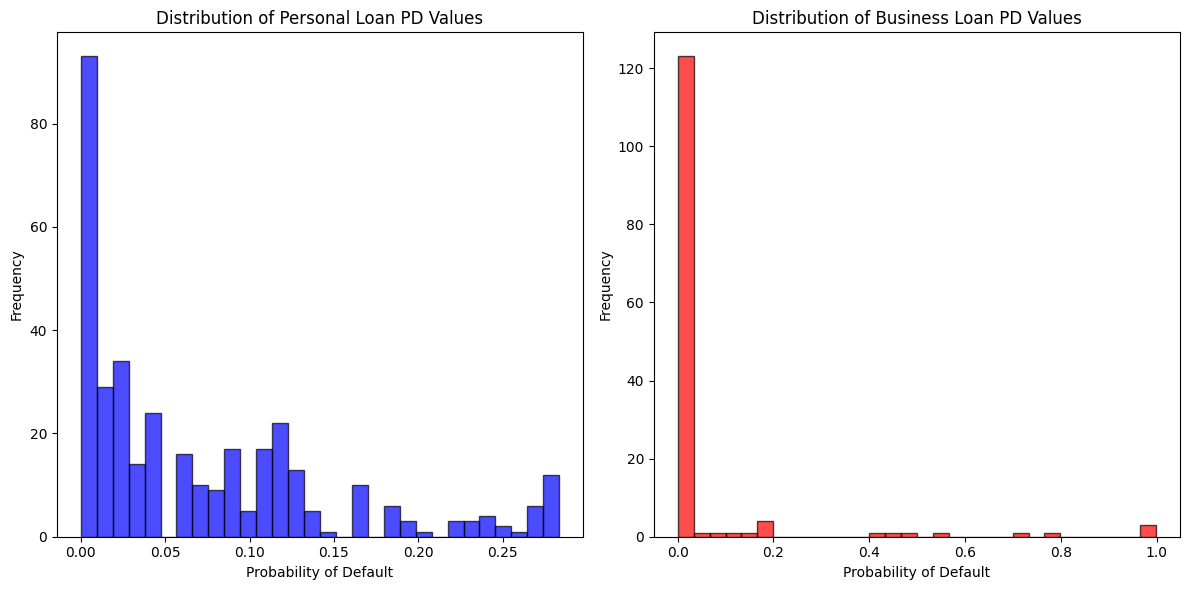

In [7]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(personal_PD, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Personal Loan PD Values')
plt.xlabel('Probability of Default')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(business_PD, bins=30, color='red', alpha=0.7, edgecolor='black')
plt.title('Distribution of Business Loan PD Values')
plt.xlabel('Probability of Default')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

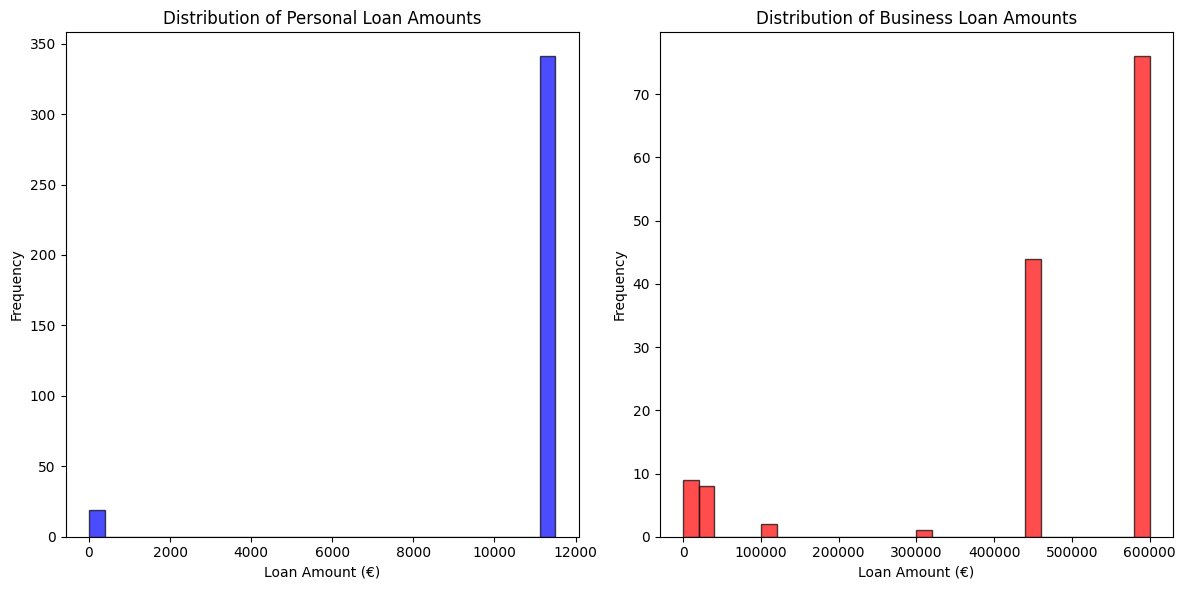

In [8]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(loan_amounts_personal, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Personal Loan Amounts')
plt.xlabel('Loan Amount (€)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(loan_amounts_business, bins=30, color='red', alpha=0.7, edgecolor='black')
plt.title('Distribution of Business Loan Amounts')
plt.xlabel('Loan Amount (€)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

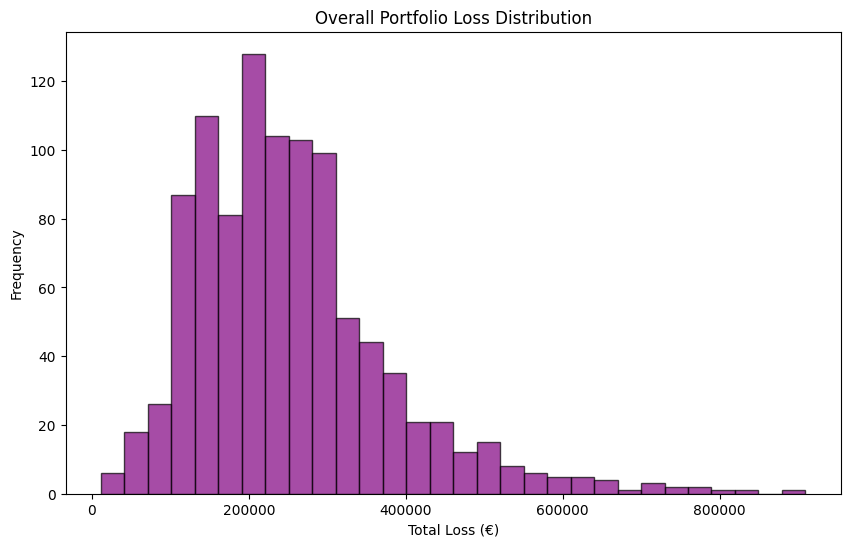

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(total_losses, bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.title('Overall Portfolio Loss Distribution')
plt.xlabel('Total Loss (€)')
plt.ylabel('Frequency')
plt.show()

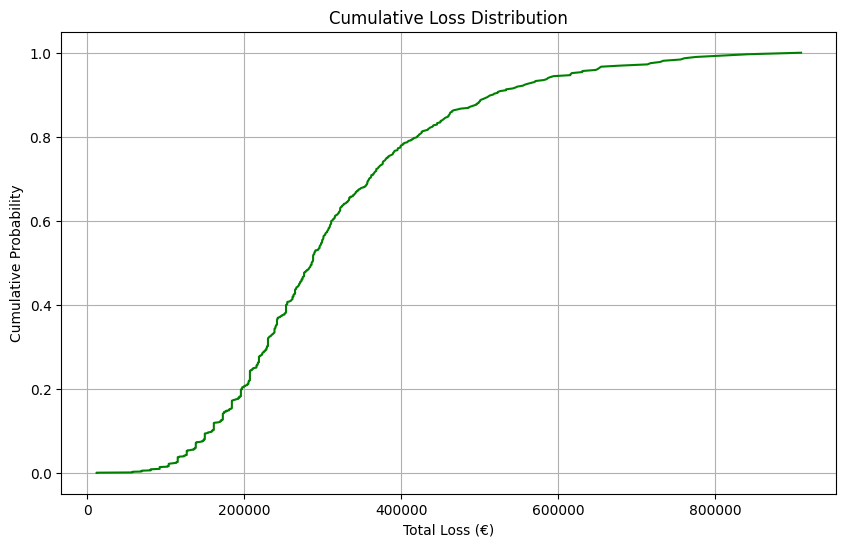

In [10]:
plt.figure(figsize=(10, 6))
sorted_losses = np.sort(total_losses)
cumulative = np.cumsum(sorted_losses) / np.sum(sorted_losses)
plt.plot(sorted_losses, cumulative, color='green')
plt.title('Cumulative Loss Distribution')
plt.xlabel('Total Loss (€)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()